# Cities with highest temperature variability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

In [2]:
# Change this address to re-run the notebook locally
folder_name = '../data/kaggle_climate/'

In [3]:
# Read the data (warning: a 500 Mb file)
df = pd.read_csv(folder_name + 'GlobalLandTemperaturesByCity.csv')
df['Date'] = pd.to_datetime(df.dt)
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude', 'Date'],
      dtype='object')

Assumptions:

1. We only consider time points after 1900
1. Variability is understood as a standard deviation of day-to-day temperatures

Now, at this point one reasonable approach would be to just take the standard deviation across all monthly values, and call it temperature variability. A potential problem with this approach is that there is also some variability within-month (both day-to-day, and within-day variabilities). We are not given these numbers directly, but we have access to a value of `AverageTemperatureUncertainty`, which was supposedly calculated based on this within-month variability.

The definition of of `AverageTemperatureUncertainty` given in the metadata claims that it is "the 95% confidence interval around the average". For independent and normally distributed data there's a simple formula linking data standard deviation (σ) to 95%CI:  $CI = \beta \sigma(x)/\sqrt{n}$, where σ() is a standard deviation, β is a value such that a t-distribution has 95% of its area between −β and β, and n is a number of points. The problem is, that temperatures within each month were certainly not normally distributed, and surely were not independent, so we don't now what formula they used.

Whether we can ignore this aspect of variability or not depends on how different these uncertainties are between different cities, and on how large these numbers are compared to the standard deviation of monthly data across the entire time period (that is, within year, and across years).

Let's for now assume that:

* this within-month variability needs to be included; 
* it was calculated from daily temperatures using the formula above, with $n \approx 30$

Then we can use a pooled variance formula: `Var_total = sqrt(Var_across_months + mean(Var_within_each_month))`. The total standard deviation will be a square root of total variance. Here we also ignore the fact that some months have 28, and some have 31 day, and go for a rough estimation.

We can calculate the top cities with and without this formula, and compare the results. If they are different, we'll think more. If they are mostly the same, then it doesn't matter.

In [4]:
# "Smart" formula that accounts for AveerageTemperatureUncertainty:

def top_variable_cities(df, n=5):
    firstdate = pd.to_datetime('1900-01-01')
    beta = scipy.stats.t.ppf(1-0.025, df=29) # Approximately 2

    dfs = (df
           .query('Date >= @firstdate')
           .assign(Within_var = (df.AverageTemperatureUncertainty/beta*np.sqrt(30))**2)
           .groupby('City')
           .agg({'AverageTemperature': 'var', 'Within_var': 'mean'})
           .reset_index()
           .set_axis(['City', 'Between_var', 'Within_var'], axis=1, inplace=False)
           .assign(SD_full = lambda x : np.sqrt(x.Between_var + x.Within_var))       
           .sort_values('SD_full', ascending=False)
           .head(n)
          )
    return dfs

dfs = top_variable_cities(df, 6)
print("Total rows:", dfs.shape[0])
dfs

Total rows: 6


,City,Between_var,Within_var,SD_full
1635,Kyzyl,267.942896,6.798217,16.575316
390,Blagoveshchensk,270.092149,3.533753,16.541641
1150,Heihe,270.092149,3.533753,16.541641
1108,Hailar,267.130769,3.548786,16.452342
3337,Yakeshi,267.130769,3.548786,16.452342
2082,Nehe,259.501455,3.120290,16.205608


Note: Blagoveshchensk and Heihe are essentially the same city, just separated by a Russia-China border. That's why same numbers. Hailar and Yakeshi are also close, in Inner Mongolia, and extremely close to each other, so they also have same numbers :/ Nehe is a bit further away, but in the same area (almost between Heihe and Yakeshi).

In [5]:
# Simple formula that ignores within-month temperature variability
# Would we get a different set of most variable cities?

firstdate = pd.to_datetime('1900-01-01')
(df
 .query('Date >= @firstdate')  
 .groupby('City')
 .agg({'AverageTemperature': 'std'})
 .reset_index()  
 .sort_values('AverageTemperature', ascending=False)
 .head(6)
)

,City,AverageTemperature
390,Blagoveshchensk,16.434481
1150,Heihe,16.434481
1635,Kyzyl,16.368961
1108,Hailar,16.344136
3337,Yakeshi,16.344136
2082,Nehe,16.109049


Conclusion: the same list really, just in a different order. This is a good news, as it means that we don't have to justify our formula for within-month variability. It also means that I wasted time deriving pooled variance formulas, as they were not needed here 😐

In [6]:
 # City names (for next task):
    
city_list = dfs.City.values.tolist()
city_list

# (Except I think I'll drop Heihe and Yakeshi, as there's no point in having 2 identical lines on the plot)

['Kyzyl', 'Blagoveshchensk', 'Heihe', 'Hailar', 'Yakeshi', 'Nehe']

In [7]:
city_list = [s for s in city_list if s not in ['Heihe', 'Yakeshi']]
city_list

['Kyzyl', 'Blagoveshchensk', 'Hailar', 'Nehe']

Note that I consciously didn't automate cities selection here. It is totally possible to automate it by pre-filtering the dataset, and excluding all cities that have identical numbers, or by doing it a 'lazy' way, and runing a `while` loop inside the function, until we get $n$ factually different cities. But in this version, the "City selector" (`top_variable_cities()`) is naive, and doesn't do a sense-check for data duplicates, which is reasonable, as Heiihe and Blagoveschensk are different cities after all. And then we can manually correct the output for the purposes of vizualization, if needed, as it would be weird to say "here's a plot of 4 cities" when actually it shows only two lines, you know?

## Visualization

The problem with "temperature uncertainty" for cyclically changing data is that if we calcualte the standard error naively, it will be greatly exaggerated due to these yearly swings of temperature. But it would not be really "uncertainty", as we can predict it. So if the task asked for a plot that shows the range of data, or the variability of data, I'd calculated a "naive" standard deviation, as we did for countries. For but "uncertanty" of data, we can do better.

Still, first, let's run a naive visualization that accounts for seasonal data swings, just to see how unhelpful it is:

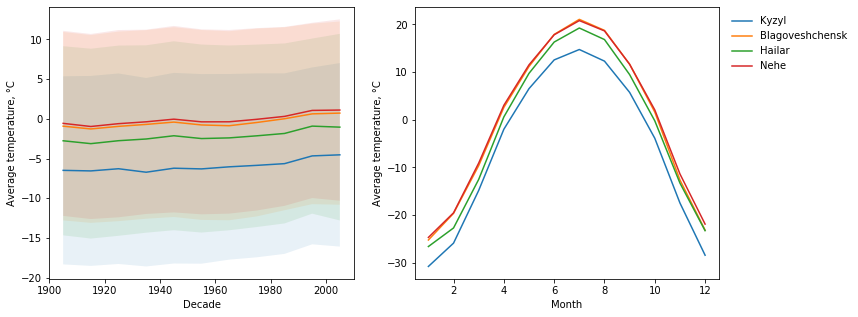

In [8]:
def plot_cities(df, names, starting_date, ending_date):
    # Naive calculation that uses SEM(temp(t)) as a measure of uncertainty.
    
    first_date = pd.to_datetime(starting_date)
    last_date  = pd.to_datetime(ending_date)
    view = df.query('Date >= @first_date & Date < @last_date & City in @names')
    
    view_monthly = (view
                    .assign(Month = df.Date.dt.month)
                    .groupby(['Month', 'City'])
                    .agg({'AverageTemperature' : 'mean'})
                    .reset_index()
                    .set_axis(['Month','City','Mean_mo'], axis=1, inplace=False)
                   )
    
    view_yearly = (view
                   .assign(Decade = (df.Date.dt.year // 10)*10)
                   .groupby(['Decade', 'City'])
                   .agg({'AverageTemperature': ['mean', 'std']})
                   .reset_index()
                   .set_axis(['Decade','City','Mean', 'SD'], axis=1, inplace=False)                                      
                  )    
    view_yearly['Error'] = view_yearly.SD/np.sqrt(10)*scipy.stats.t.ppf(1-0.025, df=9)
    
    plt.figure(figsize=(12,5), facecolor='white')
    plt.subplot(121)
    for city in names:
        subview = view_yearly.query('City == @city')
        plt.fill_between(subview.Decade + 5, 
                         subview.Mean - subview.Error, subview.Mean + subview.Error, alpha=0.1)
        plt.plot(subview.Decade + 5, subview.Mean, '-', label=city)        
        # Shift x by 5 years, to make it end at 2005, as we averaged up to 2010
    plt.xlabel('Decade')
    plt.ylabel('Average temperature, °C')
    
    plt.subplot(122)
    for city in names:
        subview = view_monthly.query('City == @city')
        plt.plot(subview.Month, subview.Mean_mo, '-', label=city)
        plt.xlabel('Month')
        plt.ylabel('Average temperature, °C')
    plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), frameon=False)
    return

plot_cities(df, city_list, '1900-01-01', '2010-01-01')

Let's now rewrite this function by canceling average yearly cycle, averaging the residuals, and then separately estimating the error. We'll assume that the temperature for every month $m$ of every year $y$ can be represented as a linear model: $t(y,m) = t_m(m) + t_y(y) + ε$. We will calculate $t_m(m)$ explicitly as monthly averages, but will then shift it to 0, so that the $\text{mean}(t_m)=0$, and the actual average for each year (and so, the change of averages for each year) "sits" in the $t_y$.

With this model, we will have 2 sources of uncertainty in average temperature estimations: the original uncertainty of monthly temperature averages (that reflects the within-month variance), and the variability of monthly temperatures. Technically, our estimations of temperature seasonality (the cyclicity we're trying to cancel) is also noisy, but this noise is be much lower. The "average temperature for August" is averaged across 110 years, and also it is not independent from the variance across decades, which means that even if we tried to account for it, we couldn't used the pooled variance formula. But as it's so much smaller, let's just ingore it. Which means that the total uncertainty will be a combination (pooled variance) of within-month and across-months uncertanties: $\sqrt{\text{var}_\text{between} + \text{var}_\text{within}}$.

The within-month uncertainties are given as 95CI, so we can scale them to SEMs (expected variability of each individual estimation). An average of $n$ independent random variables, each with dispersion of $\sigma_i$, and a fixed mean of $\mu_i$, gives a random variable with a dispersion of $\frac{1}{n}\sqrt{\sum_i \sigma_i^2}$ (as variances sum up as you sum values up, but standard deviations scale as you scale values). In practice it means, that it makes sense to transform our dataframe: 95CI → SEM → (SEM-squared) ($\sigma^2$ in formulas above), and then use either `sum()` or `mean()` aggregation function in Pandas, at the `.agg` stage; then manually scale it down. If we wanted to calculate the expected dispersion, we'd taken a square root, and scaled it down by $n$, but the formula above calls for variances (squared dispersions), so we can skip this step, and work with squared values. In terms of scaling, to calculate the expected "variance of the mean" of an average of noisy values, we will calcualte a `mean` of individual variances, and  scale it down by $n$.

For the within-decade acyclical monthly variability, we can just calculate a variance of the mean (SEM squared) by first calculating a variance of the sample `var`, then scaling it down by $n$.
  
Finally, we will combine these two sources of error, get an expected dispersion of the 10-year average, and scale it  up to get a 95%-confidence interval. We'll assume t-distribution with 10-1=9 degrees of freedom, which is an approximation, as the actual number of degrees of freedom is fractional, and slightly lower, due to the cyclical mean calculation involved in these formulas, but it feels like a reasonable simplification.

And one more thing. To make labels prettier, let's reorder cities in the sequence in which they are shown on the plot.

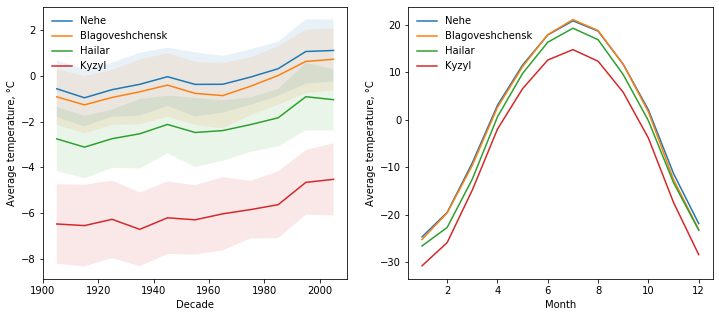

In [9]:
def plot_cities2(df, names, starting_date, ending_date):
    # Smarter version that cancels cyclicity, but also uses within-month uncertainty
    first_date = pd.to_datetime(starting_date)
    last_date  = pd.to_datetime(ending_date)
    beta30 = scipy.stats.t.ppf(1-0.025, df=29) # Approximately 2    
    beta10 = scipy.stats.t.ppf(1-0.025, df=9)
    beta100 = scipy.stats.t.ppf(1-0.025, df=99)
    view = df.query('Date >= @first_date & Date < @last_date & City in @names')
    
    view_monthly = (view
                    .assign(Month = df.Date.dt.month)
                    .assign(Var_within = np.square(df.AverageTemperatureUncertainty/beta30)) # SEM squared
                    .groupby(['Month', 'City'])
                    .agg({'AverageTemperature' : 'mean', 'Var_within': 'mean'})
                    .reset_index()
                    .set_axis(['Month','City','Mean_mo', 'Var_within'], axis=1, inplace=False)
                   )
    
    gross_averages = view_monthly.groupby('City').agg({'Mean_mo': 'mean'})
    
    view_yearly = (view
                   .assign(Decade = (df.Date.dt.year // 10)*10)
                   .assign(Month = df.Date.dt.month)
                   .assign(Var_within = np.square(df.AverageTemperatureUncertainty/beta30))
                   .merge(view_monthly, # Prepare to remove cyclicity
                         how='left',
                         on=['City','Month'],
                         suffixes=[None, '_m'])
                   .merge(gross_averages,
                         how='left',
                         on='City',
                         suffixes=[None, '_s'])
                  )    
    view_yearly.AverageTemperature -= view_yearly.Mean_mo - view_yearly.Mean_mo_s # Remove cyclicity
    view_yearly = (view_yearly                   
                   .groupby(['Decade', 'City'])
                   .agg({'AverageTemperature': ['mean', 'var'], 'Var_within': 'mean'})
                   .reset_index()
                   .set_axis(['Decade','City','Mean', 'Var_between', 'Var_within'], axis=1, inplace=False)       
                  )
    view_yearly['Error'] = np.sqrt(view_yearly.Var_between + 
                                   view_yearly.Var_within)/np.sqrt(10)*beta10
    
    # No pivoting this time around, as it's easier to plot uncertainty manually,
    # so long shape data is preferable.
    
    best_sequence = np.argsort(gross_averages.Mean_mo.values)
    names = gross_averages.index[best_sequence[::-1]]  # We want to reverse the order
        
    plt.figure(figsize=(12,5), facecolor='white')
    plt.subplot(121)
    for city in names:
        subview = view_yearly.query('City == @city')
        plt.fill_between(subview.Decade + 5, 
                         subview.Mean - subview.Error, subview.Mean + subview.Error, alpha=0.1)
        plt.plot(subview.Decade + 5, subview.Mean, '-', label=city)        
        # Shift x by 5 years, to make it end at 2005, as we averaged up to 2010
    plt.xlabel('Decade')
    plt.ylabel('Average temperature, °C')
    plt.legend(loc='upper left', frameon=False)
    
    plt.subplot(122)
    for city in names:
        subview = view_monthly.query('City == @city')
        plt.fill_between(subview.Month, 
                         subview.Mean_mo - np.sqrt(subview.Var_within)/10*beta100, 
                         subview.Mean_mo + np.sqrt(subview.Var_within)/10*beta100, alpha=0.1)        
        plt.plot(subview.Month, subview.Mean_mo, '-', label=city)
        plt.xlabel('Month')
        plt.ylabel('Average temperature, °C')
    plt.legend(loc='upper left', frameon=False)
    return

plot_cities2(df, city_list, '1900-01-01', '2010-01-01')
plt.gcf().savefig('output_plot.png', dpi=150)

## Follow-ups and sense-checks

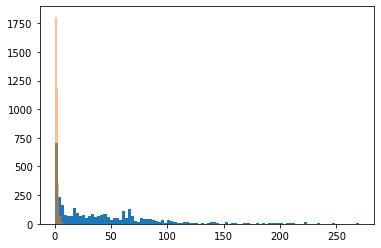

In [10]:
# Are within and between variances comparable?

dfs = top_variable_cities(df, 5000)
plt.hist(dfs.Between_var, 100);
plt.hist(dfs.Within_var, alpha=0.5);

# Not really. Which is curious, given how much temperature can fluctuate within every month.
# Perhaps my assumptions about how they calculated the uncertainty of monthly temperatures is wrong...
# Maybe they also cancelled daily variation in some way? Similarly to how I cancel monthly variation?